<script type="text/x-mathjax-config">

MathJax.Hub.Config({

  tex2jax: {inlineMath: [['$','$'], ['\\(','\\)']]}

});

</script>

<script src='https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.5/latest.js?config=TeX-MML-AM_CHTML' async></script>

## Project5 의사 결정 트리

### 1. 개요

이번 프로젝트에서는 다중 분류 문제 뿐만 아니라 회귀 문제들에까지 적용될 수 있는 강력한 모델인 의사 결정 트리(decision tree)를 구현하고자 한다.

데이터의 분석과 시각화를 위해서 미리 정의해둔 플로팅 함수들을 사용한다. 해당 함수들은 projectfiles.analyzer.graphics에 정의되어있다.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from projectfiles.analyzer.graphics import plot_decision_regions, plot_data

### 2. 분류 문제의 새로운 접근

데이터셋을 분류하는 가장 쉬운 방법 중에 하나는 샘플을 분류하는 기준을 정의하는 것이다. 예를 들어 개와 고양이를 분류하는 이진 분류기 모델이 있다고 가정해보자. 만약 이 모델이 개와 고양이를 분류할 때 귀의 모양을 가지고 분류하였다면 이 모델은 아마 성공적으로 개와 고양이를 구분할 수 있을 것이다. 왜냐하면 개의 귀는 대체로 누워있는 반면 고양이의 귀는 세워져있기 때문이다. 따라서 귀의 모양이라는 분류기준은 이 데이터셋을 구분하는데 효과적인 특징 요소라 볼 수 있다. 반대로 다리의 개수를 가지고 개와 고양이를 구분하는 모델은 분류 문제를 제대로 해결할 수 없다. 이는 당연하게도 개와 고양이의 다리의 개수가 둘 다 대체로 4개이기 때문이다.

이처럼 데이터셋을 구분할 수 있는 분류 기준을 정의하면 분류 문제를 해결할 수 있다. 문제는 어떤 특징 요소(feature element)가 분류기준으로 사용될 수 있는가 이다. 앞서 확인했듯 귀의 모양은 개와 고양이를 구분짓지만 다리의 개수는 개와 고양이를 구분짓지 못한다. 따라서 어떠한 특징 요소를 분류의 기준으로 사용할지 결정하는 것은 분류문제를 해결함에 있어 가장 중요한 과제 중 하나이다.

<blockquote>어떠한 특징 요소를 분류 기준으로 사용할 것인가?</blockquote>

### 3. 불순도

특징 요소를 추출하는 방법에 대해 알아보기 앞서 불순도(impurity)에 대해 먼저 소개하고자 한다. 불순도는 어떠한 집합 내 원소들의 다양성이 얼마나 높은지를 나타내는 지표로 다음과 같이 정의된다.

<blockquote>집합 내 원소들의 다양성이 높을수록 불순도는 높다</blockquote>

예를 들어 두 개의 서로 다른 집합 A와 B가 있다고 가정하자.

$$ A : \ <10, 90> \ , \ \ B : \ <50, 50> $$

이때 두 집합은 클래스 레이블 0과 1만을 포함한다. 만약 집합 A의 클래스 레이블 0와 1의 비율이 1:9이고 B의 비율이 5:5라면, 불순도는 집합 B가 더 높다. 왜냐하면 집합 B의 다양성이 더 높기 때문이다. 이를 수식으로 표현하면 다음과 같다:

$$ impurity(A) \lt impurity(B) $$

불순도는 여러가지 방법으로 정의할 수 있지만 의사 결정 트리를 구현할 때는 대체로 교차 엔트로피와 지니 계수를 활용한다. 집합 $S$ 내에서 임의의 원소에 대하여 클래스 레이블이 i일 확률이 $p_i$일 때, 지니 계수는 다음과 같이 정의된다:

$$ gini(S) = 1-\sum_{i}^{}(p_i)^2 $$

그리고 교차 엔트로피는 다음과 같이 정의된다:

$$ entropy(S) = -\sum_{i}^{}(p_i) \log_{2}(p_i) $$

위 식을 이용하여 집합 A와 B의 지니 계수를 구해보면 아래와 같이 나타난다.

$$ \begin{aligned} gini(A) = 1 - (\frac{1}{10})^2 - (\frac{9}{10})^2 = 0.18 \newline gini(B) = 1 - (\frac{5}{10})^2 - (\frac{5}{10})^2 = 0.50 \end{aligned}$$

또한, 위 식을 이용하여 집합 A와 B의 교차 엔트로피를 구해보면 아래와 같이 나타난다.

$$ \begin{aligned} entropy(A) = - \frac{1}{10} \log_2(\frac{1}{10}) - \frac{9}{10} \log_2(\frac{9}{10}) = 0.47 \\ entropy(B) = - \frac{5}{10} \log_2(\frac{5}{10}) - \frac{5}{10} \log_2(\frac{5}{10}) = 1.00 \end{aligned}$$

계산 결과를 확인해보면 실제로 다양성이 높을 수록 지니 계수와 교차 엔트로피가 크게 나온다는 것을 알 수 있다. 아래 그래프는 이진 분류 문제에서 확률에 따른 지니 계수와 교차 엔트로피를 나타낸 것이다.

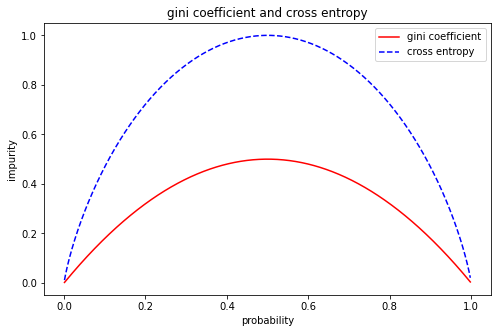

In [2]:
def gini(p):
    return 1 - p ** 2 - (1-p) ** 2

def cross_entropy(p):
    return - p * np.log2(p) - (1-p) * np.log2(1-p)

p = np.arange(0.001, 0.999, 0.001)
gin = gini(p)
ent = cross_entropy(p)

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot()

ax.plot(p, gin, 'r-', label='gini coefficient')
ax.plot(p, ent, 'b--', label='cross entropy')

ax.set_title('gini coefficient and cross entropy')
ax.set_xlabel('probability')
ax.set_ylabel('impurity')
ax.legend()

plt.show()

우리는 위의 그래프에서 다음 두 가지를 도출해낼 수 있다:

1. 지니계수와 교차 엔트로피는 확률이 0.5일 때 최대이다.
2. 지니계수의 최대값은 0.5이고, 교차 엔트로피의 최대값은 1이다.

따라서 우리는 불순도 높을수록 지니계수와 교차 엔트로피가 높음을 확인할 수 있다.

불순도를 이용하면 집합이 얼마나 잘 분류되었는지를 수치화할 수 있다. 예를 들어 집합 $S: <100, 100>$을 분류 기준 $K_1$을 이용하여 다음과 같이 두 집합 $A_1$과 $A_2$로 분류하였다고 가정하자.

$$ A_1: <10, 90> \ , \ A_2: <90, 10> $$

그리고 분류기준 $K_2$를 이용하여 다음과 같이 집합 $B_1$과 $B_2$로 분류하였다고 가정하면,

$$ B_1: <70, 50> \ , \ A_2: <30, 50> $$

각 집합의 불순도를 다음과 같이 계산할 수 있다.

$$ \begin{align} gini(S) = 1 - (\frac{100}{200})^2 - (\frac{100}{200})^2 = 0.500 
\\ gini(A_1) = 1 - (\frac{10}{100})^2 - (\frac{90}{100})^2 = 0.180
\\ gini(A_2) = 1 - (\frac{90}{100})^2 - (\frac{10}{100})^2 = 0.180
\\ gini(B_1) = 1 - (\frac{70}{120})^2 - (\frac{50}{120})^2 = 0.486
\\ gini(B_2) = 1 - (\frac{30}{80})^2 - (\frac{50}{80})^2 = 0.469 \end{align}$$

이때 직관적으로 분류기준 $K_1$과 $K_2$로 분류했을 때의 총 불순도를 다음과 같이 계산할 수 있다. (단, $P(S)$는 임의의 데이터가 집합 $S$에 속할 확률이다)

$$ \begin{align}impurity(S, A) = P(S|A_1)gini(A_1) + P(S|A_2)gini(A_2) = 0.5 \times gini(A_1) + 0.5 \times gini(A_2) = 0.180 \ \cdots \ \text{classification by using } K_1
\\ impurity(S, B) = P(S|B_1)gini(B_1) + P(S|B_2)gini(B_2) = 0.6 \times gini(B_1) + 0.4 \times gini(B_2) = 0.479 \ \cdots \ \text{classification by using } K_2 \end{align}$$

여기서 총 불순도와 집합 $S$의 불순도와의 차이를 정보이득(information gain)이라 한다. 정보이득은 원래 모집합에서 서브 집합들로 분류할 때 불순도가 얼마나 낮아졌는지를 수치화한다. 위의 분류기준 $K_1$과 $K_2$에 대한 정보이득은 다음과 같이 정의된다.

$$ \begin{align}IG(S, A) = gini(S) - impurity(S, A) = 0.320
\\\ IG(S, B) = gini(S) - impurity(S, B) = 0.021 \end{align}$$

위의 예시에서 분류기준 $K_1$을 사용했을 때 정보이득이 더 높으므로 가장 최적의 분류기준은 $K_1$이라 볼 수 있다. 이처럼 불순도를 이용하면 어떤 분류기준이 가장 최적의 분류 기준인지를 구분할 수 있다.

<blockquote>정보이득이 높은 분류기준을 이용한다</blockquote>

### 4. 의사 결정 트리의 학습과 예측과정

이제 우리는 어떤 분류 기준을 가지고 데이터셋을 분류해야 하는지를 분류도를 이용하여 계산할 수 있다. 이제부터는 실제로 앞서 소개한 불순도를 이용하여 효과적인 분류기준을 구하고, 이를 이용해 직접 분류문제를 해결하는 의사결정트리(decision tree)에 대해 설명하고자 한다.

의사결정트리는 이름에서 알 수 있듯 트리 형태의 모델이다. 트리의 각 노드는 데이터 샘플들의 집합을 의미하고, 하위노드들은 상위노드에서 분화된 서브집합들을 의미한다. 이때 상위노드에서 하위노드로 분화되는 경우 특정한 특징 요소와 그 특징 요소를 분리하는 기준이 상위노드에서 정해진다. 만약 더 이상 집합을 분리할 필요가 없으면 하위 노드를 생성하지 않고, 그 노드는 리프노드(leaf node)가 된다. 이러한 일련의 과정을 정리하면 다음과 같다:

<의사결정트리 학습과정>
1. 데이터셋 전체를 포함하는 노드를 생성한다.
2. 만약 어떠한 특징 요소를 기준으로 데이터셋을 분리했을 때 정보이득이 유의미할 정도로 크다면 집합을 분리하고, 분리된 집합들을 이용하여 하위노드들을 생성한다.
3. 더 이상 집합의 분리가 이루어지지 않을 때까지 트리를 확장한다.

그렇다면 실제로 데이터의 예측은 어떻게 이루어질까? 데이터의 예측은 데이터를 루트노드(root node)에서 리프노드로 이동시켜가면서 수행한다. 이때 상위노드에서 하위노드의 이동은 각 노드의 분류기준에 따라 수행된다. 만약 데이터가 위치한 노드가 리프노드이면, 해당 노드의 클래스 레이블을 데이터의 클래스 레이블로 예측한다. 이때 노드의 데이터 레이블은 학습할 당시에 해당 노드에서 가장 많은 클래스 레이블로 한다. 이 과정을 다음과 같이 정리한다.

<의사결정트리 예측과정>
1. 데이터를 루트노드에 위치시킨다.
2. 데이터를 결정기준에 따라 하위노드로 이동시킨다.
3. 데이터가 리프노드에 위치하면 해당 노드에서 가장 많이 발견되었던 클래스 레이블을 해당 데이터의 클래스 레이블로 예측한다.

### 5. 범주형 변수와 연속형 변수

앞서 보았던 개와 고양이를 분류하는 문제를 다시 한번 살펴보자. 이제 우리는 왜 귀의 모양이 적절한 분류기준이 될 수 있는지를 확인할 수 있다. 또한 불순도와 정보 이득 공식들을 이용하여 그 정확도를 수치적으로 계산하는 것 또한 가능하다.

여기서 주의깊게 봐야할 점은 귀의 모양이라는 특성 요소는 범주형 변수(categorical variables)라는 것이다. 범주형 변수는 해당 특성 요소에 따라 데이터가 범주화되는 변수를 의미한다. 예를 들어 앞서 확인했던 모든 개는 '누운 귀 모양'으로 범주화되고, 모든 고양이는 '세워진 귀 모양'으로 범주화된다. 범주형 변수의 경우 특별한 기준 없이 분류하는 것이 가능하다. 예를 들어 귀 모양 특징 요소는 애초에 그 값이 '누운 귀 모양'과 '세워진 귀 모양'의 두가지 밖에 없으므로, 그냥 이 두가지 범주로 구분하면 된다.

그런데 모든 변수가 항상 범주형 변수인 것은 아닌다. 상당히 많은 데이터셋에서는 연속형 변수(continuous variables)를 사용하여 데이터셋을 표현한다. 이때 연속형 변수를 이용하여 클래스를 분류하기 위해서는 정해진 기준값이 필요하다. 예를 들어 앞선 프로젝트에서 주로 사용했던 붓꽃 데이터셋의 '꽃받침 길이' 속성의 경우 그 특징값이 연속적으로 나타나므로, 꽃받침 길이을 기준으로 데이터 샘플을 분류하기 위해서는 특정한 길이가 필요하다.

문제는 어떻게 그 기준값을 정의할 수 있는가이다. 따라서 지금부터 사분위수(qualtiles)를 이용하여 기준값을 정의하는 아주 간단하면서도 효과적인 방법 하나를 제시하고자 한다. 여기서 사분위수는 백분위수 25%, 50%, 75%, 100%를 특별히 지칭하는 용어이다. 각 사분위수는 순서대로 제1 사분위수부터 제4 사분위수로 명명한다.

사분위수를 이용하면 밀도가 낮은 양 극단에 위치한 데이터들을 손쉽게 제거할 수 있다. 아래 그래프는 붓꽃 데이터셋의 0번 특성에 대하여 클래스 레이블이 'Iris versicolor'인 데이터와 'Iris virginica'인 데이터들만을 추출하여 히스토그램을 그린 것이다.

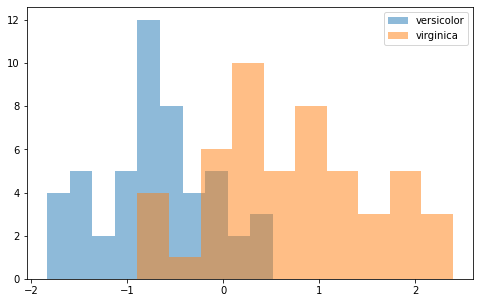

In [3]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', header=None)

X = df.iloc[0:100, 0].values
X_std = (X[:] - X[:].mean()) / X[:].std()

d1 = X_std[0:50]    # versicolor
d2 = X_std[50:100]  # virginica

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot()
ax.hist(d1, bins=10, density=False, alpha=0.5, histtype='stepfilled', label='versicolor')
ax.hist(d2, bins=10, density=False, alpha=0.5, histtype='stepfilled', label='virginica')
ax.legend(loc='upper right')
plt.show()

두 히스토그램이 겹쳐져있어 결정경계를 정의하기 쉽지 않아보인다. 문제는 이 두 히스토그램이 겹쳐져있는 이유가 각 집단의 이상치(outliers)때문이라는 것이다. 히스토그램의 양 극단의 밀도가 낮은 부분에 위치하는 모든 샘플들은 사실 전체적인 클래스 레이블의 특성을 대변하지 못한다. 따라서 결정경계를 정의하기에 앞서 이러한 이상치들을 제거하는 작업이 필요하다. 

위의 그래프에서 이상치들은 밀도가 낮은 양 극단에 위치한다. 따라서 양 극단의 데이터들을 일부 버림으로서 이상값들을 제거할 수 있다. 이상값들을 배제하는 쉬운 방법 중에 하나가 바로 사분위수를 이용하는 것이다. 위와 같이 나타나는 데이터들에서 제1 사분위수보다 크거나 같고 제 3 사분위수보다는 작은 데이터들만을 취함으로서 밀도가 낮은 부분에 위치하는 이상값들을 제거하면 다음과 같이 히스토그램이 나타난다.

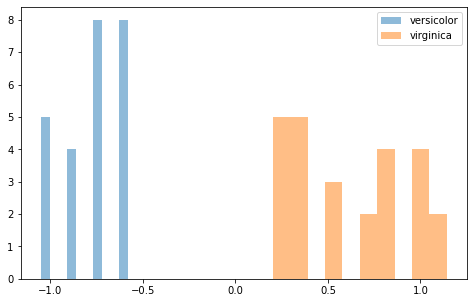

In [4]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', header=None)

X = df.iloc[0:100, 0].values
X_std = (X[:] - X[:].mean()) / X[:].std()

d1 = X_std[0:50]    # versicolor
d2 = X_std[50:100]  # virginica

d1_q1, d1_q3 = np.percentile(d1, 25), np.percentile(d1, 75)
d2_q1, d2_q3 = np.percentile(d2, 25), np.percentile(d2, 75)

d1_processed = d1[(d1 >= d1_q1) & (d1 < d1_q3)]
d2_processed = d2[(d2 >= d2_q1) & (d2 < d2_q3)]

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot()
ax.hist(d1_processed, bins=10, density=False, alpha=0.5, histtype='stepfilled', label='versicolor')
ax.hist(d2_processed, bins=10, density=False, alpha=0.5, histtype='stepfilled', label='virginica')
ax.legend(loc='upper right')
plt.show()

이제는 두 히스토그램에서 이상치들이 제거되었으므로 보다 쉽게 결정 경계를 정의할 수 있다. 위의 경우 versicolor 클래스의 제3 사분위수와 virginica 클래스의 제1 사분위수 사이에 결정 경계가 위치할 것이다. 따라서 결정 경계를 이 둘의 평균으로 정하도록 하자. 이때 연속형 변수의 결정 경계는 연속형 변수의 기준값에 의해 정해지므로 기준값을 다음과 같이 정의한다. (단, $Q_1(S)$는 집합 $S$의 제1 사분위수이고, $Q_3(S)$는 집합 $S$의 제3 사분위수이다) 

$$ criteria = \frac{max(Q_1(versicolor), Q_1(virginica)) + min(Q_3(versicolor), Q_3(virginica))}{2} $$

이때 위 공식을 일반적인 형태로 변환하면 다음과 같이 연속형 변수의 기준값 공식을 만들 수 있다.

$$ criteria = \frac{max(Q_1(S_1), Q_1(S_2)) + min(Q_3(S_1), Q_3(S_2))}{2} $$

이로써 범주형 변수들과 더불어 연속형 변수들로도 다음과 같이 분류 기준을 세울 수 있게 되었다. 이제 최종적인 학습 코드를 살펴보도록 한다.

### 6. 의사결정트리의 구현

이제 의사결정트리를 실제로 구현해보도록한다. 먼저 앞서 구한 지니계수 함수와 교차 엔트로피 함수를 개선한다. 앞서 구현한 함수들의 경우 확률값을 입력받는 함수들이었지만 이번에는 직접적으로 집합에서 불순도를 뽑아내는 형태로 만들고자 한다. 또한 집합에는 3개 이상의 클래스 레이블이 포함될 수도 있으므로 이것 또한 유의하여 구현한다.

In [5]:
def gini(s):
    ret = 1
    for element in np.unique(s):
        ret -= (np.count_nonzero(s == element) / s.shape[0]) ** 2
    return ret

def cross_entropy(s):
    ret = 0
    for element in np.unique(s):
        p = np.count_nonzero(s == element) / s.shape[0]
        if p > 0:
            ret -= p * np.log2(p)
    return ret

다음으로는 트리를 구현한다. 트리의 구조는 일반적으로 재귀적이다. 따라서 각각의 노드를 구현함으로써 트리의 구현을 마치려고 한다. 다행이도 앞서 확인했듯 트리의 학습과 예측 알고리즘 또한 재귀적으로 이루어져 있으므로 구현이 용이하다. (코드 내부의 주석을 참고하라)

In [6]:
class DecisionTreeClassifier(object):
    def __init__(self, criterion, max_depth, didx = None):
        self.criterion = criterion    # 불순도 함수 (지니 혹은 교차 엔트로피)
        # 현재 노드가 포함하는 데이터들의 인덱스에 대한 정보를 저장한다
        # 예를 들어 학습하는 데이터가 4개이고 노드가 0번과 1번 데이터를 포함하는 경우
        # self.didx => [True, True, False, False]
        self.didx = didx              
        self.max_depth = max_depth  # 트리의 최대 깊이 (재귀 시퀀스의 탈출조건으로 사용)

        self.dominant = None  # 해당 노드에서 가장 많이 발견되는 클래스 레이블
        self.impurity = None  # 해당 노드의 불순도
        self.fidx = None   # 해당 노드에서 분류 기준으로 사용하는 특성 요소의 인덱스
        self.value = None  # 연속형 변수의 경우 기준값
        self.left = None   # 좌측 하위 노드 (특성값이 기준값보다 작은 경우)
        self.right = None  # 우측 하위 노드 (특성값이 기준값보다 크거나 같은 경우)

    def fit(self, data, label, toler=0.0001):
        # 만약 노드가 루트노드인 경우 => 모두 포함하도록 self.didx를 지정
        if self.didx is None:
            self.didx = np.array([True] * data.shape[0])

        # 노드의 불순도와 가장 많이 발견되는 클래스 레이블을 계산
        label_name, label_counts = np.unique(label[self.didx], return_counts=True)
        self.impurity = self.criterion(label[self.didx])   # 불순도 계산
        self.dominant = label_name[np.where(label_counts == max(label_counts))[0][0]]  # 최빈값 계산
        
        ct = np.count_nonzero(self.didx)  # 해당 노드가 포함하는 데이터의 개수 저장
        
        # 재귀 시퀀스의 탈출조건들에 의해 해당 노드가 리프노드인지를 결정
        # 탈출조건 1: 해당 노드가 포함하는 데이터가 없는 경우
        # 탈출조건 2: 남은 깊이가 없는 경우
        # 탈출조건 3: 현재 해당 노드가 완전히 순수한 경우
        if ct == 0 or self.max_depth == 0 or np.unique(label[self.didx]).shape[0] <= 1:
            return self

        impurity_min = 2  # 최소 불순도에 대한 정보를 저장하는 변수 (불순도는 무조건 1보다는 작다)
        lidx, ridx = None, None  # 좌측하위노드와 우측하위노드에 저장되는 데이터들의 인덱스 정보
        
        # 분류하고자 하는 두 개의 클래스 레이블을 선정한다 => 어떤 클래스 레이블을 구분할 것인가?
        for pivot, name1 in enumerate(label_name):
            for name2 in label_name[pivot+1:]:
                # 분류 기준으로 삼고자 하는 특징 요소를 정한다 => 어떤 분류기준을 사용할 것인가?
                for fidx in range(data.shape[1]):
                    # 분류하고자 하는 클래스 레이블에 해당하는 데이터 추출
                    d1 = data[self.didx & (label == name1), fidx]
                    d2 = data[self.didx & (label == name2), fidx]
                    
                    # 사분위값 구하기
                    d1_q1, d1_q3 = np.percentile(d1, 25), np.percentile(d1, 75)
                    d2_q1, d2_q3 = np.percentile(d2, 25), np.percentile(d2, 75)
                    
                    # 사분위값을 이용하여 연속형 변수의 기준값 후보 구하기
                    candidate = (max(d1_q1, d2_q1) + min(d1_q3, d2_q3)) / 2
                    
                    # 실제로 데이터셋을 구분하고 좌측과 우측 하위노드에 포함될 데이터 인덱스를 정한다.
                    idx1 = self.didx & (data[:, fidx] <  candidate)  # 특징값이 기준값보다 작은 데이터 인덱스 정보
                    idx2 = self.didx & (data[:, fidx] >= candidate)  # 특징값이 기준값보다 크거나 같은 데이터 인덱스 정보

                    g1 = self.criterion(label[idx1])  # 좌측 하위노드의 불순도
                    g2 = self.criterion(label[idx2])  # 우측 하위노드의 불순도

                    ct1 = np.count_nonzero(idx1)  # 좌측 하위노드에 포함되는 데이터의 개수
                    ct2 = np.count_nonzero(idx2)  # 우측 하위노드에 포함되는 데이터의 개수
                    
                    # 해당 분류기준으로 분류했을 때 총 불순도를 구한다
                    g = (ct1 / ct) * g1 + (ct2 / ct) * g2
                    
                    # 만약 총 불순도가 이전에 구했던 최소 불순도값보다 작으면 업데이트한다
                    if g < impurity_min:
                        impurity_min = g   # 최소 불순도 업데이트
                        self.fidx = fidx   # 분류 기준 업데이트
                        self.value = candidate   # 연속형 변수의 기준값 업데이트
                        lidx, ridx = idx1, idx2  # 좌측과 우측 하위노드의 인덱스 정보 업데이트
        
        # 만약 현재 정보이득이 역치값(toler)보다 작다면 하위노드를 생성하지 않는다 (사전 가지치기)
        if self.impurity - impurity_min < toler:
            return self
        
        # 하위 노드들을 생성하고 이들에 대한 학습을 진행한다
        self.left  = DecisionTreeClassifier(criterion=self.criterion, max_depth=self.max_depth-1, didx=lidx)
        self.right = DecisionTreeClassifier(criterion=self.criterion, max_depth=self.max_depth-1, didx=ridx)

        self.left.fit(data, label)
        self.right.fit(data, label)

        return self

    def predict(self, data):
        # 데이터가 하나의 데이터 샘플인 경우
        if len(data.shape) == 1:
            if self.right is None or self.left is None:
                return self.dominant

            return self.left.predict(data) if data[self.fidx] < self.value else self.right.predict(data)
        
        # 데이터가 여러 개의 데이터 샘플로 이루어진 경우
        if self.right is None or self.left is None:           # 리프노드이면,
            return np.array([self.dominant] * data.shape[0])  # 해당 노드에서 가장 많이 발견되었던 클래스 레이블 리턴
        
        # 리프노드가 아니면, 하위 노드들에 대한 예측 진행
        d1_idx = data[:, self.fidx] <  self.value  # 촤측 하위노드로 전달될 데이터 인덱스
        d2_idx = data[:, self.fidx] >= self.value  # 우측 하위노드로 전달될 데이터 인덱스

        l1 = self.left.predict(data[d1_idx])   # 좌측 하위노드에서의 예측레이블
        l2 = self.right.predict(data[d2_idx])  # 우측 하위노드에서의 예측레이블
        
        # 좌측 하위노드에서의 레이블과 우측 하위노드에서의 레이블 통합하기
        label = np.zeros(shape=data.shape[0])
        label[d1_idx] = l1
        label[d2_idx] = l2

        return label

이제는 최종적으로 위에서 구현한 의사결정트리가 제대로 동작하는지를 확인한다. 언제나와 같이 붓꽃 데이터셋을 이용한다.

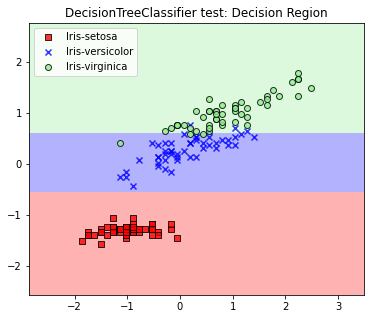

In [7]:
# 붓꽃 데이터셋 학습 알고리즘
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', header=None)

y = df.iloc[0:150, 4].values
ynames = {}

for idx, lbl in enumerate(np.unique(y)):
    y[np.where(y == lbl)] = idx
    ynames[idx] = lbl

X = df.iloc[0:150, [0, 2]].values

# standardization of the samples
X_std = np.copy(X)
X_std[:, 0] = (X[:, 0] - X[:, 0].mean()) / X[:, 0].std()
X_std[:, 1] = (X[:, 1] - X[:, 1].mean()) / X[:, 1].std()

# fitting model
model = DecisionTreeClassifier(criterion=gini, max_depth=3)
model.fit(X_std, y, toler=0.0001)

# plotting result
result = plt.figure(figsize=(6, 5))
ax = result.add_subplot()

plot_decision_regions(X_std, y, model, resolution=0.02, names=ynames, ax=ax)
ax.set_title('DecisionTreeClassifier test: Decision Region')
ax.legend(loc='upper left')

plt.show()

의사결정트리는 비선형적 결정경계를 생성할 수 있다. 아래 코드를 참조하라.

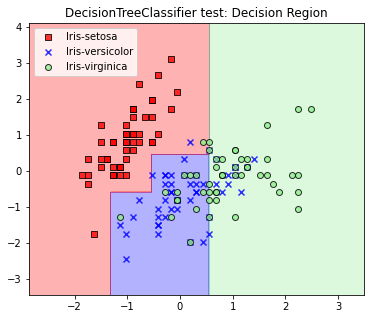

In [8]:
# 붓꽃 데이터셋 학습 알고리즘
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', header=None)

y = df.iloc[0:150, 4].values
ynames = {}

for idx, lbl in enumerate(np.unique(y)):
    y[np.where(y == lbl)] = idx
    ynames[idx] = lbl

X = df.iloc[0:150, [0, 1]].values

# standardization of the samples
X_std = np.copy(X)
X_std[:, 0] = (X[:, 0] - X[:, 0].mean()) / X[:, 0].std()
X_std[:, 1] = (X[:, 1] - X[:, 1].mean()) / X[:, 1].std()

# fitting model
model = DecisionTreeClassifier(criterion=gini, max_depth=3)
model.fit(X_std, y, toler=0.0001)

# plotting result
result = plt.figure(figsize=(6, 5))
ax = result.add_subplot()

plot_decision_regions(X_std, y, model, resolution=0.02, names=ynames, ax=ax)
ax.set_title('DecisionTreeClassifier test: Decision Region')
ax.legend(loc='upper left')

plt.show()

위에서 구현한 모델은 projecfiles.decision_tree에 저장되어있으니 참고하라.